# Set Cover Problem

In [1]:
import numpy as np
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

In [2]:
problem = pd.read_pickle('Problem.pkl')
cost = pd.read_pickle('Cost.pkl')

In [3]:
def plot_DiGraph(dictionary, cost, title):
    edges = []
    facilities = []
    for node in dictionary.items():
        facility = 'F' + str(node[0])
        edges += list(zip(itertools.repeat(facility),node[1]))
        facilities.append(facility)
        
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    withcost = dict(zip(facilities, cost))
    colors = [withcost.get(node, 5) for node in graph.nodes()]
    fig = plt.figure(figsize = (16, 9))
    pos = nx.shell_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_size = 700, node_color = colors, cmap=plt.get_cmap('Reds'))
    nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edges(graph, pos, arrows=True)
    plt.title(title)
    plt.show()

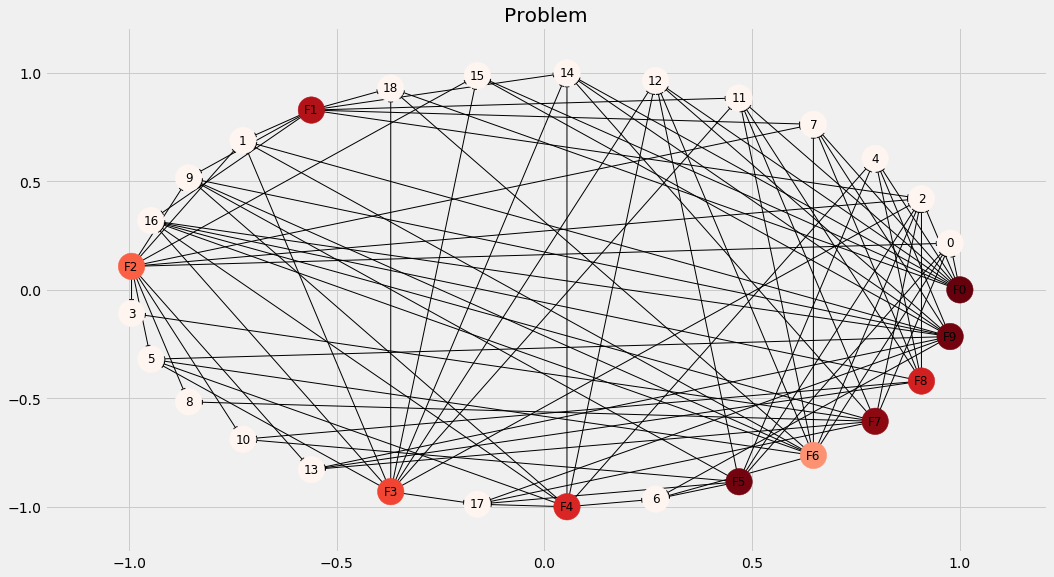

In [4]:
plot_DiGraph(problem, cost, 'Problem')

### Solving using IP (docplex)

In [5]:
from docplex.mp.model import Model

In [6]:
scp = Model(name = 'Set Cover')

In [7]:
x = {(i): scp.binary_var(name = f'f_{i}') for i in problem.keys()}

scp.minimize(scp.sum(x[i] * cost[i] for i in problem.keys()))

In [8]:
all_values = []
for val in problem.values():
    all_values.extend(val)
    
all_values = set(all_values)

In [9]:
problem_t = dict()
for key in all_values:
    problem_t[key] = set()

In [10]:
for key,value in problem.items():
    for i in value:
        problem_t[i].add(key)

In [11]:
for dn in problem_t.values():
    scp.add_constraint(scp.sum(x[i] for i in dn) >= 1)

In [12]:
scp_sol = scp.solve()

In [13]:
scp_sol.display()

solution for: Set Cover
objective: 79
f_2 = 1
f_4 = 1
f_6 = 1


<hr>

### Solving using Genetic Algorithm

In [14]:
target_length = len(problem)
n_population = 10
n_iterations = 100

In [15]:
def norm(ls):
    max_ls = max(ls)
    return [x / (max_ls + 10**-6) for x in ls]

def create_solution(length):
    return [1 if np.random.uniform() > 0.5 else 0 for _ in range(length)]

def create_population(pop_size, length):
    return [create_solution(length) for _ in range(pop_size)]

def select_parents(population, fitness):
    total = sum(fitness)
    p = [x/total for x in fitness]
    temp = [x for x in range(0, len(population))]
    choice = np.random.choice(temp, 2, replace = False, p = p)
    return population[choice[0]], population[choice[1]]

def crossover(x, y):
    if len(x) == len(y):
        breakpoint = np.random.randint(1, len(x))
        return x[0:breakpoint] + y[breakpoint:], y[0:breakpoint] + x[breakpoint:]
    else:
        print('Length mismatch')
    
def mutate(x, flip_threshold = 0.5, n_place = 1):
    for _ in range(n_place):
        flip_index = np.random.randint(0, len(x))
        x[flip_index] = abs(1 - x[flip_index]) if np.random.uniform() > flip_threshold else x[flip_index]
    return x

def display(withfit, generation):
    print(f'Generation : {generation}')
    solution = [str(x[0]) for x in withfit]
    cover = [str(x[1][0]) for x in withfit]
    cost = [str(-1 * x[1][1]) for x in withfit]
    n_facility = [str(-1 * x[1][2]) for x in withfit]
    print(pd.DataFrame({'Solution' : solution, 'Cover' : cover, 'Facilities Used' : n_facility, 'Cost' : cost}))
    print('x'.center(100, '-'))
    
def calc_metrics(prospect):
    cover_elements = []
    nodes = 0
    for i, j in enumerate(prospect):
        if j != 0:
            nodes += 1
            cover_elements.extend(problem[i])
            
    cover_elements = set(cover_elements)
    cover = len(cover_elements)

    cx = sum(cost * prospect)
    
    return [cover, -1 * cx, -1 * nodes]

def calc_fitness(withfit):
    pop_arr = np.array([x[0] for x in withfit])
    norm_cover = np.array(norm([x[1][0] for x in withfit]))
    norm_facilities = np.array(norm([x[1][2] for x in withfit]))
    norm_costs = np.array(norm([x[1][1] for x in withfit]))
    return norm_costs + norm_cover + norm_facilities

In [16]:
population = create_population(n_population, target_length)
norm_cost = np.array(norm(cost))
generation = 0
while True:
    metrics = list(map(calc_metrics, population))
    withfit = list(zip(population, metrics))
    withfit = sorted(withfit, key = lambda x : (x[1][0], x[1][1], x[1][2]) , reverse = True)
    fitness = calc_fitness(withfit)
    if generation == n_iterations:
        display(withfit, generation)
        print(f'Result after {n_iterations} iterations')
        solution = withfit[0][0]
        print(f'Solution = {solution}')
        print(f'Cover Cardinality = {-1 * withfit[0][1][2]}')
        print(f'Cover = {withfit[0][1][0]}')
        print(f'Cost = {sum(np.array(withfit[0][0]) * np.array(cost))}')
        break
    nextgen = [x[0] for x in withfit[:2]]
    for _ in range(0, (n_population - 2)//2):
        parent1, parent2 = select_parents(population, fitness)
        child1, child2 = crossover(parent1, parent2)
        children = [mutate(x) for x in [child1, child2]]
        nextgen += children

    population = nextgen
    generation +=1
    if generation % 10 == 0:
        display(withfit, generation)

Generation : 10
                         Solution Cover Facilities Used Cost
0  [0, 0, 1, 1, 1, 0, 0, 1, 0, 0]    19               4  130
1  [0, 0, 1, 1, 1, 0, 0, 1, 0, 0]    19               4  130
2  [0, 0, 1, 1, 1, 0, 0, 1, 0, 0]    19               4  130
3  [0, 0, 1, 1, 1, 0, 0, 1, 0, 0]    19               4  130
4  [0, 0, 1, 1, 1, 1, 0, 1, 0, 0]    19               5  174
5  [1, 0, 1, 1, 1, 0, 0, 1, 0, 0]    19               5  175
6  [0, 0, 1, 1, 1, 0, 1, 1, 1, 0]    19               6  184
7  [0, 1, 1, 1, 1, 1, 0, 1, 0, 0]    19               6  212
8  [0, 0, 1, 0, 1, 0, 0, 0, 1, 0]    18               3   93
9  [1, 0, 0, 1, 1, 1, 1, 0, 1, 0]    17               6  205
-------------------------------------------------x--------------------------------------------------
Generation : 20
                         Solution Cover Facilities Used Cost
0  [0, 0, 1, 1, 1, 0, 0, 0, 0, 0]    19               3   88
1  [0, 0, 1, 1, 1, 0, 0, 0, 0, 0]    19               3   88
2  [0, 0, 1, 

In [17]:
solution_dict = {}
for i, check in enumerate(solution):
    if check == 1:
        solution_dict[i] = problem[i]

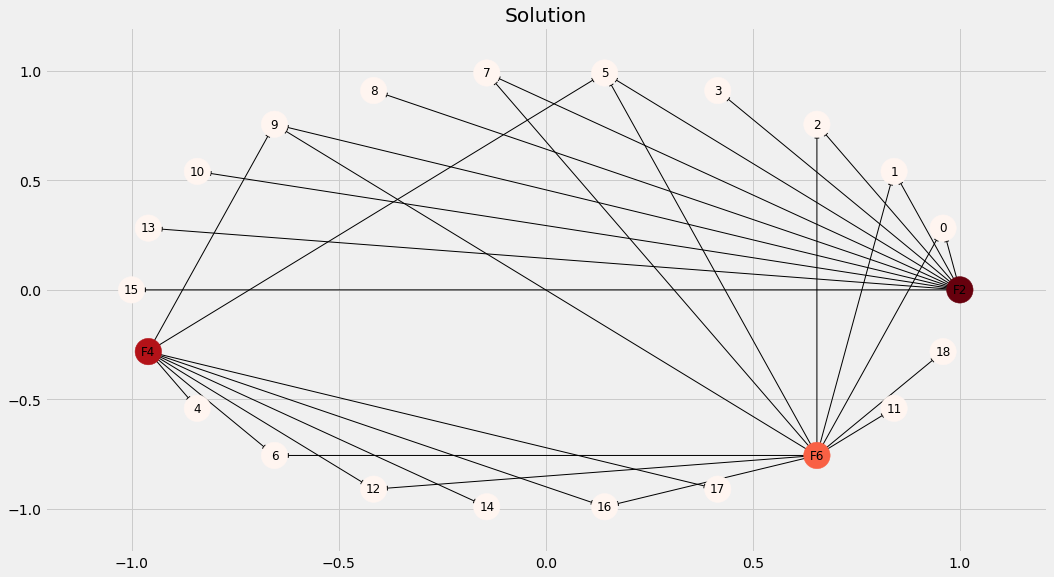

In [18]:
plot_DiGraph(solution_dict, cost, 'Solution')

<hr>